Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Lazy resampling benchmark

In this notebook, we used 3D spleen segmentation task to show our lazy-resampling benchmark. Our results include the following two main parts.
- Time spent on each transform and the total amount of data preparation in the lazy and non-lazy mode.
- End-to-end time comparison

## Setup environment

In [16]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm, gdown]"

## Setup imports

In [2]:
import os
import time
import glob
import torch
import tempfile
import numpy as np
import monai
import monai.transforms as mt
from monai.utils import WorkflowProfiler
from monai.apps import download_and_extract

from monai.config import print_config

print_config()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.2.0rc4+9.ge18097d0
Numpy version: 1.22.2
Pytorch version: 1.13.0a0+d0d6b1f
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: e18097d0a8ba323ee66aeb7830d296bf54f44bdd
MONAI __file__: /workspace/Code/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
ITK version: 5.3.0
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.10.1
gdown version: 4.6.0
TorchVision version: 0.14.0a0
tqdm version: 4.64.1
lmdb version: 1.3.0
psutil version: 5.9.2
pandas version: 1.4.4
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.0.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Setup data directory
You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/Data


## Download dataset and prepare the utilities

This section downloads and extracts the dataset.

The dataset comes from http://medicaldecathlon.com/.

`TraceObjectsOnly` is used to narrow the scope of the trace to top-level transforms only.

In [4]:
class TraceObjectsOnly:
    def __init__(self, objects):
        self.objects = objects

    def __call__(self, frame):
        self_obj = frame.f_locals.get("self", None)
        return frame.f_code.co_name == "__call__" and self_obj in self.objects


resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Set MSD Spleen dataset path

In [5]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Transform Profiling Comparison

`transform_list` shows the transform chain used in non-lazy mode.
- `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
- `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
- `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
- `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
- `Orientationd` unifies the data orientation based on the affine matrix.
- `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
- `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
- `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [6]:
monai.utils.set_determinism(24)
transform_list = [
    mt.LoadImaged(keys=["image", "label"], image_only=True),
    mt.EnsureChannelFirstd(keys=["image", "label"]),
    mt.ScaleIntensityRanged(
        keys=["image"],
        a_min=-57,
        a_max=164,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    mt.CropForegroundd(keys=["image", "label"], source_key="image"),
    mt.Orientationd(keys=["image", "label"], axcodes="RAS"),
    mt.Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    mt.RandCropByPosNegLabeld(
        keys=["image", "label"],
        label_key="label",
        spatial_size=(96, 96, 96),
        pos=1,
        neg=1,
        num_samples=4,
        image_key="image",
        image_threshold=0,
    ),
    mt.RandAffined(
        keys=["image", "label"],
        mode=("bilinear", "nearest"),
        prob=1.0,
        spatial_size=(96, 96, 96),
        rotate_range=(0, 0, np.pi / 15),
        scale_range=(0.1, 0.1, 0.1),
    ),
]
xform = mt.Compose(transform_list)

`transform_list_lazy` shows the transform chain used in lazy mode.

In this particular example, we need to modify the `transform_list` in two places to enable lazy resampling:
- because the `RandCropByPosNegLabeld` relies on the `label` input to compute foreground and background indices, so we add `Identityd` before it to applying pending operations on `label`.
- the final `Identityd` is added to calculate to final applying time, in the real case, we can comment this transform and it will be executed automatically at the end of the `Compose`.

In [7]:
monai.utils.set_determinism(24)
transform_list_lazy = [
    mt.LoadImaged(keys=["image", "label"], image_only=True),
    mt.EnsureChannelFirstd(keys=["image", "label"]),
    mt.ScaleIntensityRanged(
        keys=["image"],
        a_min=-57,
        a_max=164,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    mt.CropForegroundd(keys=["image", "label"], source_key="image"),
    mt.Orientationd(keys=["image", "label"], axcodes="RAS"),
    mt.Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    mt.Identityd(keys=["label"]),
    mt.RandCropByPosNegLabeld(
        keys=["image", "label"],
        label_key="label",
        spatial_size=(96, 96, 96),
        pos=1,
        neg=1,
        num_samples=4,
    ),
    mt.RandAffined(
        keys=["image", "label"],
        mode=("bilinear", "nearest"),
        prob=1.0,
        spatial_size=(96, 96, 96),
        rotate_range=(0, 0, np.pi / 15),
        scale_range=(0.1, 0.1, 0.1),
    ),
    mt.Identityd(keys=["image", "label"]),
]

lazy_kwargs = dict(mode=("bilinear", 0), padding_mode=("border", "nearest"), dtype=(torch.float32, torch.uint8))
xform_lazy = mt.Compose(
    transform_list_lazy, lazy_evaluation=True, override_keys=("image", "label"), overrides=lazy_kwargs
)

### The preprocessing pipeline evaluated non-lazily

In [8]:
dataset = monai.data.Dataset(train_files, transform=xform)
data_loader = monai.data.DataLoader(dataset, batch_size=1)

with WorkflowProfiler(TraceObjectsOnly(transform_list)) as wp:
    time_start = time.time()
    for item_non_lazy in data_loader:
        pass
    time_process = time.time() - time_start

print(f"non-lazy preprocessing time: {time_process}")
wp.get_times_summary_pd()

non-lazy preprocessing time: 53.942039012908936


,Count,Total Time (s),Avg,Std,Min,Max
LoadImaged.__call__,32,23.626085,0.738315,0.378356,0.224879,1.628534
Spacingd.__call__,32,18.758536,0.586204,0.230448,0.205977,0.972495
RandAffined.__call__,128,7.533578,0.058856,0.003341,0.055322,0.081781
ScaleIntensityRanged.__call__,32,1.745978,0.054562,0.020078,0.021689,0.099323
CropForegroundd.__call__,32,1.045209,0.032663,0.010443,0.015115,0.053857
RandCropByPosNegLabeld.__call__,32,0.899153,0.028099,0.008210,0.015004,0.045086
Orientationd.__call__,32,0.066212,0.002069,0.000417,0.001774,0.003228
EnsureChannelFirstd.__call__,32,0.010026,0.000313,0.000044,0.000268,0.000458


### The preprocessing pipeline evaluated lazily

In [9]:
dataset = monai.data.Dataset(train_files, transform=xform_lazy)
data_loader = monai.data.DataLoader(dataset, batch_size=1)

with WorkflowProfiler(TraceObjectsOnly(transform_list_lazy)) as wp:
    time_start = time.time()
    for item_lazy in data_loader:
        pass
    time_process = time.time() - time_start

print(f"lazy preprocessing time: {time_process}")
wp.get_times_summary_pd()

lazy preprocessing time: 40.177658557891846


,Count,Total Time (s),Avg,Std,Min,Max
LoadImaged.__call__,32,21.722101,0.678816,0.353406,0.229194,1.545509
ScaleIntensityRanged.__call__,32,1.690793,0.052837,0.020176,0.021944,0.097047
CropForegroundd.__call__,32,0.967980,0.030249,0.008874,0.014580,0.045386
RandCropByPosNegLabeld.__call__,32,0.724851,0.022652,0.007175,0.011137,0.033919
RandAffined.__call__,128,0.163268,0.001276,0.000131,0.001104,0.001903
Spacingd.__call__,32,0.108466,0.003390,0.000124,0.003232,0.003817
Orientationd.__call__,32,0.059240,0.001851,0.000064,0.001737,0.002000
EnsureChannelFirstd.__call__,32,0.009414,0.000294,0.000025,0.000261,0.000337
Identityd.__call__,160,0.002594,0.000016,0.000010,0.000007,0.000041


## End-to-end workflow Profiling Comparison

https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb contains the complete workflow. 'transform_list_lazy' or 'transform_list' should be used in place of the 'train_transforms' and 'val_transforms'.

### Total time comparison

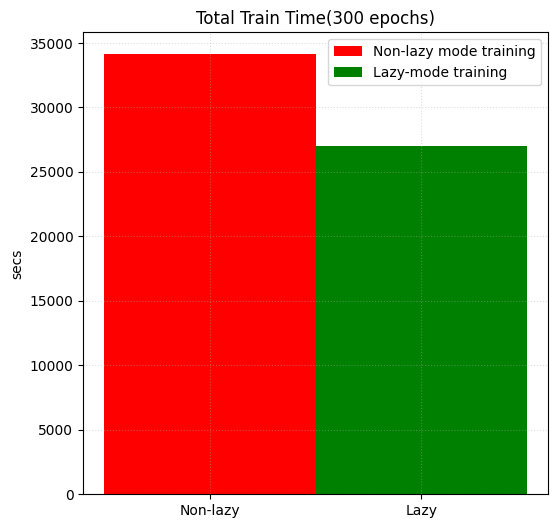

In [1]:
import matplotlib.pyplot as plt
plt.figure("train", (6, 6))
plt.title("Total Train Time(300 epochs)")
plt.bar("Non-lazy", 34122.5508, 1, label="Non-lazy mode training", color="red")
plt.bar("Lazy", 27040.6345, 1, label="Lazy-mode training", color="green")
plt.ylabel("secs")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")

### performance curve comparison